In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from termcolor import colored
import sys

from results import psos, benchmarks
from results.flc.ruggedness import fem_0_1 as fem0_1_results, \
    fem_0_01 as fem0_01_results
from results.flc.neutrality import pn as pn_results, \
    lsn as lsn_results
from results.flc.gradients import g_avg as g_avg_results, \
    g_dev as g_dev_results
from results.flc.funnels import dm as dm_results
from results.flc.deception import fdc as fdc_results
from results.flc.searchability import fci_soc as fci_soc_results, \
    fci_cog as fci_cog_results, \
    fci_sigma as fci_sigma_results
from results import drocs as droc_results
from util.chunks import chunks

getting db connection...
getting db cursor...
db ready.


In [9]:
# Params

pso_names = psos.all_names
swarm_size = 25
benchmark_names = benchmarks.all_names
benchmark_names = sorted(benchmark_names)
num_iterations = 2000
num_experiments = 30

flcs = {
    'fem0_1': fem0_1_results,
    'fem0_01': fem0_01_results,
    'pn': pn_results,
    'lsn': lsn_results,
    'g_avg': g_avg_results,
    'g_dev': g_dev_results,
    'dm': dm_results,
    'fdc': fdc_results,
    'fci_cog': fci_cog_results,
    'fci_soc': fci_soc_results,
    'fci_sigma': fci_sigma_results
}
flc_names = flcs.keys()


In [11]:
# Data getter helpers

def get_flcs(flc_name, benchmark_name):
    # Get the measure function for the given name
    flc_measure = flcs[flc_name]
    
    # Determine which dimensionality to use
    D = 5
    benchmark = benchmarks.get(benchmark_name)
    if not benchmark.is_dimensionality_valid(D):
        D = 2
    
    # Get the results for each experiment
    results = []
    for e in range(num_experiments):
        result = flc_measure.get(benchmark_name, D, e)
        results.append(result)
    
    return results



In [13]:
# DRoCs

droc_dict = {}
for pso_name in pso_names:
    pso_dict = {}
    for benchmark_name in benchmark_names:
        D = 5
        benchmark = benchmarks.get(benchmark_name)
        if not benchmark.is_dimensionality_valid(D):
            D = 2

        droc_vals = []
        for e in range(num_experiments):
            droc = droc_results.get(
                pso_name, swarm_size, benchmark_name, D, num_iterations, e)
            droc_vals.append(droc)
        pso_dict[benchmark_name] = droc_vals
    droc_dict[pso_name] = pso_dict
droc_df = pd.DataFrame(droc_dict)


In [21]:
# Only look at Gbest PSO (for now!)
pso_name = 'gbest_pso'

# The results
X_raw = {}

for benchmark_name in benchmark_names:
    progress_msg = '\rProcessing ' + benchmark_name
    sys.stdout.write('\r                                       ')
    sys.stdout.write(progress_msg)
    sys.stdout.flush
    
    # The results for this benchmark function, in list format.
    X = pd.Series()
    
    # Get the mean DRoC value for this benchmark name:
    drocs = droc_df[pso_name][benchmark_name]
    droc_mean = np.average(drocs)
    X = X.append(pd.Series({'DRoC': droc_mean}))
    
    # Each FLC
    for flc_name in flcs.keys():
        flc_measures = get_flcs(flc_name, benchmark_name)
        flc_measures_mean = np.average(flc_measures)
        X = X.append(pd.Series({flc_name: flc_measures_mean}))
    
    # Save the series for this benchmark function to the results.
    X_raw[benchmark_name] = X

print ''
print 'Done.'
data = pd.DataFrame(X_raw)
data = data.transpose()

Processing zakharov                    
Done.


In [178]:
# Define inputs and outputs

input_names = [
#     'dm',
#     'lsn',
    'fdc',
    'fci_sigma',
    'fem0_01',
#     'fem0_1',
    'g_avg',
    'fci_soc',
#     'g_dev',
    'pn',
#     'fci_cog'
]
output_name = 'DRoC'

X = data[input_names]
y = data[output_name]


In [179]:
# Set up a fitting pipeline.

# Params:
degree = 2

# Components etc
pf = PolynomialFeatures(degree=degree)
lm = linear_model.LinearRegression()
pipeline = Pipeline([
    ('pf', pf),
    ('lm', lm)
])


In [182]:
# Here, we will use all the data as training data

# Params
print_model = True

# Do the fit:
pipeline.fit(X, y)

# Get the model -- print the coefficients
if print_model:
    print 'model:'
    lm = pipeline.named_steps['lm']
    pf = pipeline.named_steps['pf']
    print zip(lm.coef_, pf.get_feature_names())
    print ''

# Predict
y_pred = pipeline.predict(X)

# Score the prediction
from sklearn.metrics import mean_squared_error
print 'mse:', mean_squared_error(y, y_pred)

from sklearn.metrics import r2_score
print 'r2:', r2_score(y, y_pred)

from sklearn.metrics import explained_variance_score
print 'e.v.:', explained_variance_score(y, y_pred)


model:
[(-1.6343144011443655e-06, '1'), (-756.59369269270189, 'x0'), (19537.720938568451, 'x1'), (-263.27930999170587, 'x2'), (-222.47527876843435, 'x3'), (-1106.5196040594662, 'x4'), (-4370.6125724484964, 'x5'), (-212.35480833830439, 'x0^2'), (9361.8387524537175, 'x0 x1'), (-596.46884436560322, 'x0 x2'), (32.389053604183346, 'x0 x3'), (1198.4367522930893, 'x0 x4'), (-14142.950127163995, 'x0 x5'), (-107905.43193119031, 'x1^2'), (-4684.9378940608649, 'x1 x2'), (986.54385373349771, 'x1 x3'), (-19132.525097381724, 'x1 x4'), (54.165689677795044, 'x1 x5'), (309.94611267586185, 'x2^2'), (-32.315769833576617, 'x2 x3'), (527.02205582364093, 'x2 x4'), (-8990.1084093470308, 'x2 x5'), (9.3122566208220245, 'x3^2'), (171.76314675557472, 'x3 x4'), (16073.656327763549, 'x3 x5'), (265.73698267734017, 'x4^2'), (-7274.2770837564176, 'x4 x5'), (-41.987108638240606, 'x5^2')]

mse: 1.24954492685
r2: 0.965207083992
e.v.: 0.965207083992


In [167]:
# Now we'll split training and test data and see what that does.

# Params:
test_size = .1
print_model = False

# Split:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

# Fit:
pipeline.fit(X_train, y_train)

# Get the model -- print the coefficients
if print_model:
    print 'model:'
    lm = pipeline.named_steps['lm']
    pf = pipeline.named_steps['pf']
    print zip(lm.coef_, pf.get_feature_names())
    print ''

# Predict
y_pred = pipeline.predict(X_test)

# Score the prediction
from sklearn.metrics import mean_squared_error
print 'mse:', mean_squared_error(y_test, y_pred)

from sklearn.metrics import r2_score
print 'r2:', r2_score(y_test, y_pred)

from sklearn.metrics import explained_variance_score
print 'e. v.:', explained_variance_score(y_test, y_pred)


mse: 302.860215179
r2: -0.592820813775
e. v.: -0.193253233866


Clearly, we overfitted -- an r-squared score of 1 should be impossible, considering the amount of randomness; also, we get really bad scores during cross-validation.

How do we improve?
1. We can reduce the number of inputs and find the best combination of inputs. A better evaluator of the model would be the adjusted r-squared (see [this](http://blog.minitab.com/blog/adventures-in-statistics-2/multiple-regession-analysis-use-adjusted-r-squared-and-predicted-r-squared-to-include-the-correct-number-of-variables)).
2. We probably should include more data points. I believe we're only fitting to the averages now, and so we probably have more terms in the polynomial than datapoints to fit to! By including all samples, we'd hopefully make it harder for the model to overfit.
3. We can use [non-linear regression](http://blog.minitab.com/blog/adventures-in-statistics-2/linear-or-nonlinear-regression-that-is-the-question); however, this could make it harder to analyse the relationships between predictors and outcomes, which is the only real purpose of this exercise.

Another consideration is: how will we include the various PSOs in the model? Can we represent them by categorical types? Should we give them numbers?

## More datapoints

Instead of averages, let's fit to all 30 samples for each variable.

We'd actually like something like a 3d dataframe here, with dimensions for
1. FLC/DRoC
2. Benchmark
3. Sample

But maybe we can just duplicate benchmark rows for samples.

In [193]:
# Only look at Gbest PSO (for now!)
pso_name = 'gbest_pso'

# The results
X_raw = {}

for benchmark_name in benchmark_names:    
    for e in range(30):
        percent = ((e+1) * 100) / 30
        progress_msg = '\rProcessing ' + benchmark_name + ' ({}%)'.format(percent)
        sys.stdout.write('\r                                                 ')
        sys.stdout.write(progress_msg)
        sys.stdout.flush

        # The results for this benchmark function for this experiment (sample num):
        X = pd.Series()
    
        # Get the mean DRoC value for this benchmark/experiment
        droc = droc_df[pso_name][benchmark_name][e]
        X = X.append(pd.Series({'DRoC': droc}))
    
        # Each FLC
        for flc_name in flcs.keys():
            flc_measure = get_flcs(flc_name, benchmark_name)[e]
            X = X.append(pd.Series({flc_name: flc_measure}))
            
        # Save the series for this benchmark function to the results.
        row_id = benchmark_name + '_' + '{}'.format(e)
        X_raw[row_id] = X

print ''
print 'Done.'
data = pd.DataFrame(X_raw)
data = data.transpose()


Processing zakharov (100%)                       
Done.


In [194]:
data.head()

,DRoC,dm,lsn,fdc,fci_sigma,fem0_01,fem0_1,g_avg,fci_soc,g_dev,pn,fci_cog
ackley_0,-2.138723,-0.209901,0.0,0.743467,0.022316,0.881727,0.856617,3.410970,0.874,2.738077,0.0,0.622
ackley_1,-1.874630,-0.210407,0.0,0.661996,0.022316,0.878835,0.864010,3.910437,0.894,2.877590,0.0,0.582
ackley_10,-1.410084,-0.221065,0.0,0.696685,0.022316,0.873037,0.848276,4.371486,0.898,2.881730,0.0,0.596
ackley_11,-0.939707,-0.194162,0.0,0.656592,0.022316,0.883494,0.850962,3.143371,0.874,2.533255,0.0,0.570
ackley_12,-1.543953,-0.189737,0.0,0.619107,0.022316,0.881835,0.849616,4.965046,0.898,3.297928,0.0,0.606


In [196]:
# Define inputs and outputs

input_names = [
    'dm',
    'lsn',
    'fdc',
    'fci_sigma',
    'fem0_01',
    'fem0_1',
    'g_avg',
    'fci_soc',
    'g_dev',
    'pn',
    'fci_cog'
]
output_name = 'DRoC'

X = data[input_names]
y = data[output_name]


In [197]:
# Set up a fitting pipeline.

# Params:
degree = 2

# Components etc
pf = PolynomialFeatures(degree=degree)
lm = linear_model.LinearRegression()
pipeline = Pipeline([
    ('pf', pf),
    ('lm', lm)
])


In [209]:
# Here, we will use all the data as training data

# Params
print_model = False

# Do the fit:
pipeline.fit(X, y)

# Get the model -- print the coefficients
if print_model:
    print 'model:'
    lm = pipeline.named_steps['lm']
    pf = pipeline.named_steps['pf']
    print zip(lm.coef_, pf.get_feature_names())
    print ''

# Predict
y_pred = pipeline.predict(X)

# Score the prediction
from sklearn.metrics import mean_squared_error
print 'mse:', mean_squared_error(y, y_pred)

from sklearn.metrics import r2_score
print 'r2:', r2_score(y, y_pred)

from sklearn.metrics import explained_variance_score
print 'e.v.:', explained_variance_score(y, y_pred)


mse: 17.853498541
r2: 0.543737520626
e.v.: 0.543737520626


When using all inputs, we get a far more realistic evaluation :)

For cross validation, maybe we should also get scores for the predicted y based on the training data, and then see how much those scores differ from the scores based on test data?

In [208]:
# Now we'll split training and test data and see what that does.

# Params:
test_size = .1
print_model = False

# Split:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

# Fit:
pipeline.fit(X_train, y_train)

# Get the model -- print the coefficients
if print_model:
    print 'model:'
    lm = pipeline.named_steps['lm']
    pf = pipeline.named_steps['pf']
    print zip(lm.coef_, pf.get_feature_names())
    print ''

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

#
# Evaluate the prediction on the training data:
#

# Predict:
y_pred = pipeline.predict(X_train)

print 'train:'
print 'mse:', mean_squared_error(y_train, y_pred)
print 'r2:', r2_score(y_train, y_pred)
print 'e. v.:', explained_variance_score(y_train, y_pred)

#
# Evaluate the prediction on the test data:
#

# Predict
y_pred = pipeline.predict(X_test)

# Score the prediction

print 'test:'
print 'mse:', mean_squared_error(y_test, y_pred)
print 'r2:', r2_score(y_test, y_pred)
print 'e. v.:', explained_variance_score(y_test, y_pred)


train:
mse: 17.1050630779
r2: 0.531072281015
e. v.: 0.531072281015
test:
mse: 28.673614737
r2: 0.543248983858
e. v.: 0.543265675734


This one's weird because you get better/worse results (where the model predicts the training data better or worse) based on how the data is split for cross validation. So there's probably some more and less important predictors in the data, and the question is just which ones they are?

Let's figure out how to do **adjusted r squared**.

Here's a [stackoverflow post](https://stackoverflow.com/questions/42033720/python-sklearn-multiple-linear-regression-display-r-squared) with some code that does it.

As a function:

In [273]:
def adjusted_r2_score(y, y_pred):
    SS_Residual = sum((y-y_pred)**2)
    SS_Total = sum((y-np.mean(y))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    return adjusted_r_squared

Now we can follow two routes.

We can try and find the best complete model by trying different input combinations.
For this, it would be cool to automate the process by trying all possible input combinations and ranking them by their `adjusted_r2_scores`. That way, the input combo with the best score will yield the most complete explanation.

Alternatively, we can build models from simple input combos (limited to 2 or 3 inputs) that are easy to interpret. We can then discuss these models easily -- e.g., we might say that ruggedness increases DRoC, but the effect is mitigated by deception (just talking out of my ass though :). Not sure how we'd select these models to discuss -- maybe just select the small models with the greatest explanatory power?

As per Jade's advice, we should probably go for whatever is easiest to discuss.
However, it might be easier to focus on small models once we know which predictors are the most significant, by trying out all models, or by examining the best model.

So let's start by creating and evaluating all models.

In [332]:
def score(X, y, degree):
    pf = PolynomialFeatures(degree=degree)
    lm = linear_model.LinearRegression()
    pipeline = Pipeline([
        ('pf', pf),
        ('lm', lm)
    ])
    
    pipeline.fit(X, y)
    
    y_pred = pipeline.predict(X)
    return adjusted_r2_score(y, y_pred), pipeline

from itertools import combinations

all_flc_names = flcs.keys()
best_r = -float('inf')
best_inputs = []
best_degree = 0
best_model = None
best_y_pred = []
best_residuals = []

# max_inputs = len(all_flc_names)
max_inputs = 4 # actually up to max_inputs-1
max_degree = 4 # actually up to max_degree-1
play_by_play = True
for l in range(1, max_inputs):
    for degree in range(1, max_degree):
        combos = combinations(all_flc_names, l)
        for (i, combo) in enumerate(combos):
            print '\rprocessing... (in:{}/deg:{}/combo:{})                       \r'.format(l, degree, i),
            flc_names = list(combo)
            X = data[flc_names]
            y = data['DRoC']
            r, pipeline = score(X, y, degree)
            if r > best_r:
                if play_by_play:
                    print '\rNew best:                                                 '
                    print 'score:', r
                    print 'inputs:', flc_names
                    print 'degree:', degree
                    print ''
                best_r = r
                best_inputs = flc_names
                best_degree = degree
                lm = pipeline.named_steps['lm']
                pf = pipeline.named_steps['pf']
                best_model = zip(lm.coef_, pf.get_feature_names())
                y_pred = pipeline.predict(X)
                best_y_pred = y_pred
                best_residuals = y - y_pred

print ''
print '\nbest:'
print 'score:', best_r
print 'inputs:', best_inputs
print 'degree:', best_degree
print 'model:', best_model

New best:                                                 
score: 0.0199310821864
inputs: ['dm']
degree: 1

New best:                                                 
score: 0.0379026585671
inputs: ['fdc']
degree: 1

New best:                                                 
score: 0.0451723977835
inputs: ['fci_sigma']
degree: 1

New best:                                                 
score: 0.0557087250927
inputs: ['dm']
degree: 2

New best:                                                 
score: 0.071577674932
inputs: ['fdc']
degree: 2

New best:                                                 
score: 0.0827659246775
inputs: ['fci_sigma']
degree: 2

New best:                                                 
score: 0.0893614887606
inputs: ['dm']
degree: 3

New best:                                                 
score: 0.102397126484
inputs: ['fdc']
degree: 3

New best:                                                 
score: 0.144410190256
inputs: ['dm', 'fci_sigma']
degree: 2

N

In [276]:
# Sanity check

X = data[['dm']]
y = data['DRoC']
degree = 1

pf = PolynomialFeatures(degree=degree)
lm = linear_model.LinearRegression()
pipeline = Pipeline([
    ('pf', pf),
    ('lm', lm)
])
pipeline.fit(X, y)
y_pred = pipeline.predict(X)
score = adjusted_r2_score(y, y_pred)
print score

0.0199310821864


In [306]:
# The best model with actual input names

s = str(best_model)

def _replacing_term(s, term_num, inputs):
    if len(inputs) > term_num:
        term_name = 'x{}'.format(term_num)
        s = s.replace(term_name, inputs[term_num])
    return s

# Go down (so that we replace '10' before '1')
for i in range(len(best_inputs), -1, -1):
    s = _replacing_term(s, i, best_inputs)

print s

[(0.0, '1'), (933.1011588914472, 'dm'), (2338.5242662091482, 'fci_sigma'), (-295.03700694840529, 'fem0_01'), (1205.165638752062, 'dm^2'), (-52220.980392731806, 'dm fci_sigma'), (807.50701664999701, 'dm fem0_01'), (-310770.39600258926, 'fci_sigma^2'), (11729.787799430624, 'fci_sigma fem0_01'), (293.44472907762417, 'fem0_01^2'), (1260.474904613066, 'dm^3'), (-26150.750681352431, 'dm^2 fci_sigma'), (317.78730467138126, 'dm^2 fem0_01'), (541281.50803261495, 'dm fci_sigma^2'), (-840.68166413358631, 'dm fci_sigma fem0_01'), (-671.37632092148624, 'dm fem0_01^2'), (1514289.910456819, 'fci_sigma^3'), (323341.12849280896, 'fci_sigma^2 fem0_01'), (-24305.59818525059, 'fci_sigma fem0_01^2'), (131.46142380177625, 'fem0_01^3')]


In [317]:
import seaborn as sns
print best_inputs

['dm', 'fci_sigma', 'fem0_01']


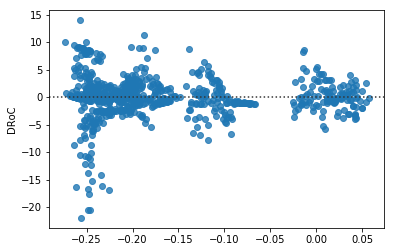

In [318]:
flc_name = ['dm']
X = data[flc_name]
sns.residplot(X, best_residuals)

This actually looks kinda good? definitely higher residuals at low values, but better than I expected.

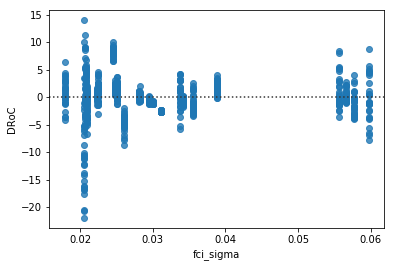

In [319]:
flc_name = 'fci_sigma'
X = data[flc_name]
sns.residplot(X, best_residuals)

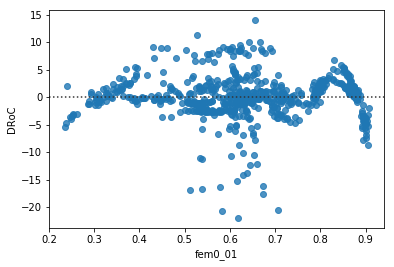

In [331]:
flc_name = 'fem0_01'
X = data[flc_name]
sns.residplot(X, best_residuals)

For FEM_0.01, there seems to be some issues.

And in general, resid seems to depend on X, somewhat

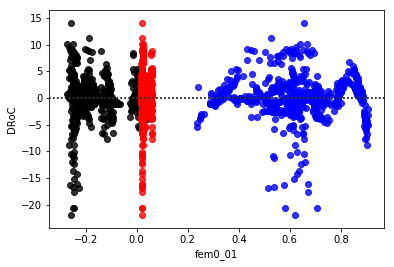

In [328]:
# Combined:

colors = ['black', 'red', 'blue']
for (i, flc_name) in enumerate(best_inputs):
    X = data[flc_name]
    sns.residplot(X, best_residuals, color=colors[i])

Ok, let's call that 'playing with the data'.

We can now get the best model with up to _n_ inputs and up to _m_ degrees, print the model as expressed by its coefficients, and plot residuals for each input. Nice!

Now is probably the time to extract something from this that we can actually write about.

We should probably
- Limit the degree to a low value, preferably 2, and
- Find the best model (in terms of adjust r^2), all terms considered
- Discuss that model

And also
- Consider a number of simpler models consisting of fewer terms, also in a low degree
- (Be able to motivate our selection)
- Discuss those models

(actually, if we could limit the polynomial degree to 1, that would be ideal, but we'd probably get useless models)

Also, should we consider other types of regression that are less prone to overfitting? Ideally, I'd say yes, but do we have time? We do not.

Also, **TODO**: We should have used all the data for the single flc correlation coefficients, and not just means. Update and see if anything needs to change.
(Edit: looks like it might already be like that. Just double check.)

# A. Best model

## All terms considered

(TODO: find the best model and get all data needed to discuss it)

In [340]:
all_flc_names = flcs.keys()
best_r = -float('inf')
best_inputs = []
best_degree = 0
best_model = None
best_y_pred = []
best_residuals = []

max_inputs = len(all_flc_names)
max_degree = 3 # actually up to max_degree-1
for l in range(1, max_inputs):
    for degree in range(1, max_degree):
        combos = combinations(all_flc_names, l)
        for (i, combo) in enumerate(combos):
            print '\rprocessing... (in:{}/deg:{}/combo:{})                       \r'.format(l, degree, i),
            flc_names = list(combo)
            X = data[flc_names]
            y = data['DRoC']
            r, pipeline = score(X, y, degree)
            if r > best_r:
                best_r = r
                best_inputs = flc_names
                best_degree = degree
                lm = pipeline.named_steps['lm']
                pf = pipeline.named_steps['pf']
                best_model = zip(lm.coef_, pf.get_feature_names())
                y_pred = pipeline.predict(X)
                best_y_pred = y_pred
                best_residuals = y - y_pred

print ''
print '\nbest:'
print 'score:', best_r
print 'inputs:', best_inputs
print 'degree:', best_degree
print 'model:', best_model

processing... (in:10/deg:2/combo:10)                       

best:
score: 0.53648111053
inputs: ['dm', 'lsn', 'fdc', 'fci_sigma', 'fem0_01', 'fem0_1', 'g_avg', 'fci_soc', 'g_dev', 'fci_cog']
degree: 2
model: [(2.0705794280478976e-05, '1'), (354.19161453305736, 'x0'), (7876.1322659858024, 'x1'), (22.1171303961791, 'x2'), (4730.0567543969946, 'x3'), (-96.73345214568927, 'x4'), (-8.8962029823281625, 'x5'), (-30.197958063755618, 'x6'), (-111.42375405284442, 'x7'), (14.775734719562479, 'x8'), (-42.624740018824291, 'x9'), (135.6335063184095, 'x0^2'), (5973.2934550410728, 'x0 x1'), (-77.982117558093961, 'x0 x2'), (-1001.7044342376762, 'x0 x3'), (-87.052998458440499, 'x0 x4'), (-46.343921733502128, 'x0 x5'), (-28.618697917465539, 'x0 x6'), (98.284175977016474, 'x0 x7'), (14.877412344308425, 'x0 x8'), (-237.18360144872668, 'x0 x9'), (10159.891607484149, 'x1^2'), (1908.0465932107641, 'x1 x2'), (-322664.67721439776, 'x1 x3'), (-1100.9662979043294, 'x1 x4'), (5875.8866364866644, 'x1 x5'), (153.045

In [341]:
print len(best_model)

66


# B. Other models

## With fewer inputs considered

TODO 1: Explore and pick a few models. The idea should probably be to cover all FLCs?

TODO 2: Find all data needed to discuss models.

# Writing it up

The above is only for a single PSO.
- Should we average the terms across all PSOs? 
- Should we plot them? We can (might??) do a nice parallel coordinates plot to see which terms are consistently significant

Also, I'm worried that we didn't explicitly avoid overfitting, and might still be susceptible. Check out ways to do that and/or check for that. EDIT: the way to avoid overfitting is to include enough data, and I think we have enough.